# Your Title Here

**Name(s)**: Akanksha, Megha

**Website Link**: (your website link)

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
pd.options.plotting.backend = 'plotly'

from lec_utils import * 
# Feel free to uncomment and use this. It'll make your plotly graphs look like ours in lecture!

## Step 1: Introduction

## Step 2: Data Cleaning and Exploratory Data Analysis

In [2]:
recipes_path = 'RAW_recipes.csv'
raw_recipes_path = pd.read_csv(recipes_path)
cleaned_recipes = raw_recipes_path.copy()
cleaned_recipes.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')

In [3]:
interactions_path = 'RAW_interactions.csv'
raw_interactions_path = pd.read_csv(interactions_path)
cleaned_interactions = raw_interactions_path.copy()


In [4]:
#cleaning mins 
cleaned_recipes['minutes'] = pd.to_numeric(cleaned_recipes['minutes'], errors='coerce')
bins = [0,30,60,120,180,360,720,1440]
bin_labels = ["(0-30]", "(30, 60]", "(60, 120]", "(120, 180]", "(180, 360]", "(360, 720]", "(720, 1440]"]

cleaned_recipes['min_bins'] = pd.cut(cleaned_recipes['minutes'], bins=bins, labels = bin_labels)
cleaned_recipes = cleaned_recipes.dropna(subset=['min_bins'])
cleaned_recipes = cleaned_recipes[cleaned_recipes['minutes'] > 0]




In [5]:
#cleaning up nutrients
nutrition_info = ['calories', 'total fat (PDV%)', 'sugar (PDV%)', 'sodium (PDV%)', 'protein (PDV%)', 'saturated fat (PDV%)', 'carbohydrates (PDV%)']

for i, key in enumerate(nutrition_info):
    cleaned_recipes[key] = cleaned_recipes['nutrition'].apply(lambda x: x.split(',')[i][1:])

    if i == len(nutrition_info) - 1:
        cleaned_recipes[key] = cleaned_recipes[key].apply(lambda x: x[:-1])

    cleaned_recipes[key] = cleaned_recipes[key].astype(float)

nutrition_cols = cleaned_recipes[['calories', 'total fat (PDV%)', 'sugar (PDV%)', 'sodium (PDV%)', 'protein (PDV%)', 'saturated fat (PDV%)', 'carbohydrates (PDV%)']]


In [6]:

#https://www.fda.gov/food/nutrition-facts-label/added-sugars-nutrition-facts-label
#https://nutrition.ucdavis.edu/outreach/nutr-health-info-sheets/pro-fat
# https://www.mayoclinic.org/healthy-lifestyle/nutrition-and-healthy-eating/expert-answers/fat-grams/faq-20058496
# https://www.mayoclinic.org/healthy-lifestyle/nutrition-and-healthy-eating/in-depth/carbohydrates/art-20045705
#https://www.fda.gov/food/nutrition-education-resources-materials/sodium-your-diet
#https://www.medicalnewstoday.com/articles/protein-intake
# https://www.medicalnewstoday.com/articles/protein-intake


In [7]:
recipes = cleaned_recipes[
    (cleaned_recipes['calories'] <= 500) & (cleaned_recipes['calories'] >= 50) &
    (cleaned_recipes['sugar (PDV%)'] <= 20) & (cleaned_recipes['sugar (PDV%)'] >= 5) &
    (cleaned_recipes['sodium (PDV%)'] <= 20) &
    (cleaned_recipes['saturated fat (PDV%)'] <= 10) &
    (cleaned_recipes['total fat (PDV%)'] <= 35) &
    (cleaned_recipes['carbohydrates (PDV%)'] <= 65) &
    (cleaned_recipes['protein (PDV%)'] <= 35)
]

cleaned_recipes['healthy'] = cleaned_recipes['id'].apply(
    lambda x: 1 if x in recipes['id'].values else 0
)


In [8]:
#cleaning up interactions
recipe_interactions = cleaned_interactions.groupby('recipe_id').agg({
    'rating': 'mean',     
    'review': 'count',     
}).reset_index()
recipe_interactions

,recipe_id,rating,review
0,38,4.25,4
1,40,5.00,3
2,41,4.00,1
...,...,...,...
185910,537543,0.00,1
185911,537671,0.00,1
185912,537716,5.00,1


In [9]:
cleaned_interactions['date'] = pd.to_datetime(cleaned_interactions['date'])

interactions_by_date = cleaned_interactions.groupby(cleaned_interactions['date'].dt.to_period('M')).agg({
    'rating': 'mean',     
    'review': 'count',    
}).reset_index()

interactions_by_date.head()

,date,rating,review
0,2008-01,4.55,17497
1,2008-02,4.37,14144
2,2008-03,4.44,13373
3,2008-04,4.48,13313
4,2008-05,4.50,12129


In [10]:
#merging 
merged_data = pd.merge(cleaned_recipes, cleaned_interactions, 
                       left_on='id', 
                       right_on='recipe_id', 
                       how='left')
merged_data['rating'] = merged_data['rating'].replace(0, np.nan)
average_rating_per_recipe = merged_data.groupby('recipe_id')['rating'].mean()
cleaned_recipes['average_rating'] = cleaned_recipes['id'].map(average_rating_per_recipe)


/var/folders/nb/8vchymhs2nx7448fccfm8bk00000gn/T/ipykernel_34520/2947629161.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



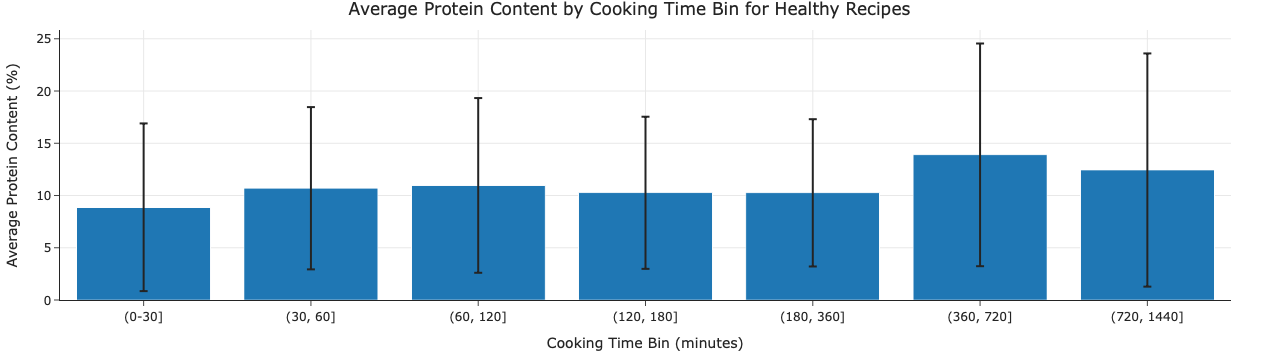

In [33]:
#plots
healthy_recipes = cleaned_recipes[cleaned_recipes['healthy'] == 1]
avg_protein_by_time_bin = healthy_recipes.groupby('min_bins')['protein (PDV%)'].agg(['mean', 'std']).reset_index()

fig = px.bar(
    avg_protein_by_time_bin,
    x='min_bins',
    y='mean',
    error_y='std',
    title='Average Protein Content by Cooking Time Bin for Healthy Recipes',
    labels={
        'min_bins': 'Cooking Time Bin (minutes)',
        'mean': 'Average Protein Content (%)',
        'std': 'Standard Deviation'
    },
)

fig.show()

/var/folders/nb/8vchymhs2nx7448fccfm8bk00000gn/T/ipykernel_34520/629939045.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



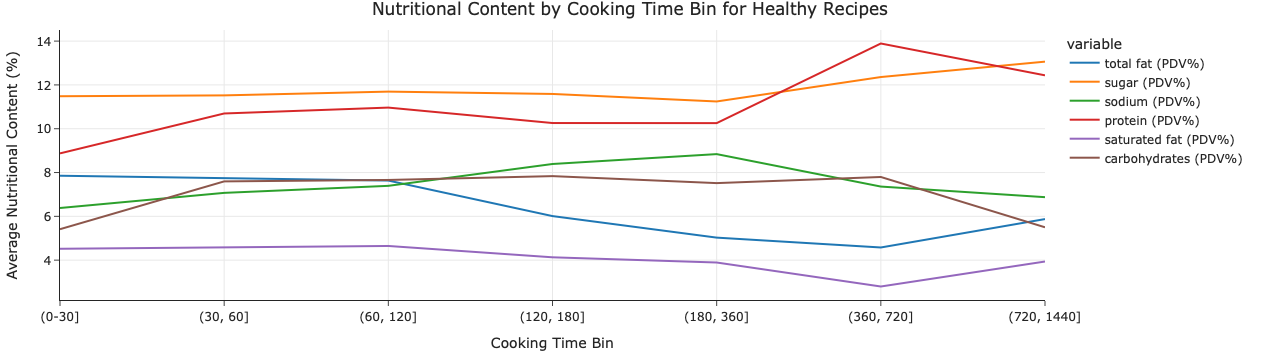

In [32]:
# Group by cooking time bin
avg_nutrients_by_bin = healthy_recipes.groupby('min_bins')[['total fat (PDV%)', 'sugar (PDV%)', 'sodium (PDV%)', 'protein (PDV%)', 'saturated fat (PDV%)', 'carbohydrates (PDV%)']].mean().reset_index()

# Plot
fig = px.line(
    avg_nutrients_by_bin,
    x='min_bins',
    y=['total fat (PDV%)', 'sugar (PDV%)', 'sodium (PDV%)', 'protein (PDV%)', 'saturated fat (PDV%)', 'carbohydrates (PDV%)'],
    title='Nutritional Content by Cooking Time Bin for Healthy Recipes',
    labels={'value': 'Average Nutritional Content (%)', 'min_bins': 'Cooking Time Bin'},
)
fig.show()


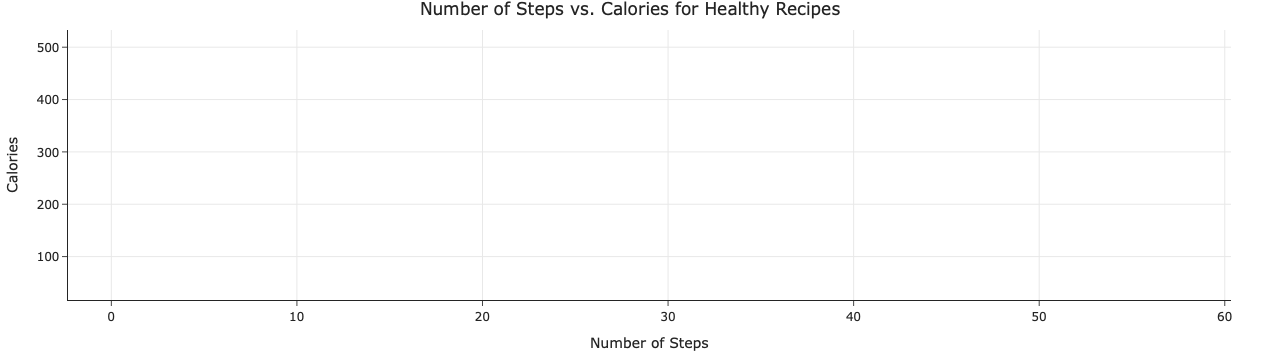

In [34]:
fig = px.scatter(
    healthy_recipes,
    x='n_steps',
    y='calories',
    title='Number of Steps vs. Calories for Healthy Recipes',
    labels={
        'n_steps': 'Number of Steps',
        'calories': 'Calories'
    },
)

fig.update_layout(
    xaxis_title='Number of Steps',
    yaxis_title='Calories',

)

fig.show()

## Step 3: Framing a Prediction Problem

In [ ]:
# TODO

## Step 4: Baseline Model

In [ ]:
# TODO

## Step 5: Final Model

In [ ]:
# TODO